# Age and Gender Conditional GAN (agcGAN)

***agcGAN (Age-Gender Conditional Generative Adversarial Networks)***

<a name="Introduction"></a>
[INTRODUCTION](#Introduction)

The goal of this project is to create an **Age-Gender Conditional Generative Adversarial Networks**. It was inspired by a recent paper (7 Feb 2017) [FACE AGING WITH CONDITIONAL GENERATIVE ADVERSARIAL NETWORKS](http://arxiv.org/abs/1702.01983).
Using a vanilla Conditional Generative Adversarial Networks, we will add two conditions to it (age and gender) so that we could
generate from unseen pictures an outpout image according to a pre-selected age; The gender will be automatically determined.
Two functionalities will be implemented during the development:

    ---> From an unseen input image generate the age and gender on faces
    ---> From an unseen input image generate an outpout image on faces with respect to a pre-selected age

The difference with other methods such as CNN is that we choose to work only with ***GANs, which are recent improvements in the field of Deep Learning, always in exploration. ***

**You could find more detail on the [Github Readme](https://github.com/Kjeanclaude/Fast-AI-Courses/tree/master/Part-2/acGAN%20Paper%20Implementation).**

The main challenges are:
- **1- Find an age and gender labeled dataset to train our implementations :** Find dozen of face images from the internet with their correct age and gender is easy. But when you talk about several thousands of images, ***the task is very hard and expensive***. We could not have access to the ***private IMDB-Wiki cleaned Dataset*** of the original paper. So, during our research we coincidently found the free ***Age and Gender Classification Dataset of the Open University of Israel (Face Image Project)*** which as 8 classes of age instead of 6 as in the original paper. ***A lot of thanks to them.***
- **2- Transform the dataset to reach our goals :** The Age and Gender Classification Dataset has some very good implementations in Tensorflow for Data preparation and tests. But as it was only for a CNN project and they do not implement a aging process. We should rewrite our own functions to reach our goals, using their annotations for the provided dataset. We need to match separate age and gender with their corresponding image ID and implement the aging process functions.
- **3- Try our implementation on video and mobile app :** It is not too hard to label pictures in video when we don't have to simultaneously deal with the audio too. But we could have some surprises sometime because of frameworks dependencies. Moreover, at this time (April 2017) we don't have enough ressources about the transformation process of Deep learning Frameworks projects into mobile apps. Run a Deep learning code in a notebook implementation and run it as mobile app are very different. Each framework has its constraints, no universal methods for this (crossplatform iOS-Android-Windows Mobile, several frameworks, etc.). 

The main steps of implementation are:
- **1- Data preparation :** create a dictionary of age and gender including all training set images
- **2- One-hot labels :** create a dictionary of age and gender including all training set images
- **3- Age and Gender Prediction :** create an ANN and train it with the prepared data to predict age and gender.
- **4- agcGAN implementation :** Now that we know how to predict age and gender from unseen images, we will use the IcGAN process method to implement the agcGAN; generate an outpout image according to a pre-defined range of age.

## Requirements
In the **import section** you will find all the required frameworks for the code to work. We mainly work with :

- **Tensorflow** and its advanced API **Tflearn**.
- **Python 2.x** and **Python 3.x** branches (You could run the notebook code where you want)


Below the Table of contents. We try to be as clear as possible for pedagogical reasons, so that newbies could also get what they need.
<a name="Table_of_Contents"></a>
# Table of Contents
- [Introduction](#Introduction)
- [I- Data Preparation](#Data_Preparation)
    - [I.1- Fondamental functions for data preparation](#Fondamental_functions)
    - [I.2- The One-Hot Labels](#One_Hot_Labels)
    - [I.3- The Training sets](#training_sets)
        - [I.3.1- The Train_x dictionary](#Train_x_dictionary)
        - [I.3.2- The Train_y dictionary (One-Hot Labels of Train_x)](#Train_y_dictionary)
    - [I.4- The test sets](#test_sets)
        - [I.4.1- The Test_x dictionary](#Test_x_dictionary)
        - [I.4.2- The Test_y dictionary (One-Hot Labels of Test_x)](#Test_y_dictionary)
    - [I.5- The Validation sets](#validation_sets)
        - [I.5.1- The Validation_x dictionary](#Validation_x_dictionary)
        - [I.5.2- The Validation_y dictionary (One-Hot Labels of Validation_x)](#Validation_y_dictionary)
    - [I.6- Datasets Transformation into lists](#Datasets_transformation_lists)
        - [I.6.1- The Train_x and Train_y lists](#Train_xy_lists)
        - [I.6.2- The Validation_x and Validation_y lists](#Validation_xy_lists)
        - [I.6.3- The Test_x and Test_y lists](#Test_xy_lists)

- [II- Age and Gender Prediction](#age_gender_prediction)
    - [II.1- Build the Artificial Neural Network (ANN) Model](#ANN_Model)
        - [II.1.1- With TFlearn](#ANN_Model_TFlearn)
        - [II.1.2- With Tensorflow](#ANN_Model_Tensorflow)
    - [II.2- Predictions on the Model](#prediction_on_Model)
        - [II.2.1- With images from the dataset](#prediction_on_dataset)
        - [II.2.2- With other face images](#prediction_on_otherFaces)
        - [II.2.3- With non-faces images](#prediction_on_NonFaces)
 
- [III- The acgGAN implementation](#acgGAN_implementation)
    - [III.1- Parameters setting](#parameter_setting)
    - [III.2- Next Batch function](#next_batch_function)
    - [III.3- The aging label function](#aging_label_function)
    - [III.4- Generate labels with an cVAE (as for the ANN Model)](#Generate_labels_cVAE)    
    - [III.5- The agcGAN Network](#agcGAN_Network)
        - [III.5.1- The agcGAN Network implementation](#agcGAN_Network_implementation)
        - [III.5.2- The agcGAN Network Evaluation](#agcGAN_Network_Evaluation)


- [IV- Video implementation of the acgGAN](#acgGAN_Video)


- [V- Deployment of the acgGAN on a Mobile App](#acgGAN_Mobile_App)


- [CONCLUSION](#conclusion)

In [1]:
# Import all the required libraries
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tensorflow as tf
import tflearn
import data
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imresize
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

print("tf.__version__ : ", tf.__version__)
print("python --version : ", sys.version)
#print("tflearn --version : ", tflearn.__version__)
PyVersion = sys.version

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
tf.__version__ :  1.0.0
python --version :  3.5.3 | packaged by conda-forge | (default, Feb  9 2017, 15:12:38) [MSC v.1900 64 bit (AMD64)]


<a name="Data_Preparation"></a>
# I- Data preparation
<a name="Fondamental_functions"></a>
## I.1- Fondamental functions for data preparation

- Using the differents training set files 

The goal is to create all the necessary functions to link each image to its gender and age, such as *age_gender_per_image*).
    
    To do it we will use the files in [./AgeGenderDeepLearning/Folds/train_val_txt_files_per_fold] directory. In each fold we have these files : {age_test.txt, age_train.txt, age_train_subset.txt, age_val.txt, gender_test.txt, gender_train.txt, gender_train_subset.txt, gender_val.txt}.
* The functions will mainly keep images ids in dictionaries of age and gender. For example : ***age_gender_dic = {"id_image":(age_class, gender)}***

<font color='red'>Note: Here we do not work on the dataset itself directly. But we only use the images' names saved in the files.</font>

In [2]:
# THE FOLDS PATH : TRAINING, VALIDATION AND TEST FOLDS
print("PyVersion[0] : '{}'".format(PyVersion[0]))

if int(PyVersion[0])==2:
    folds_path='/notebooks/AgeGenderDeepLearning/Folds/train_val_txt_files_per_fold' 
    print("Jean-Claude, I got in python 2")
else:
    folds_path='C:\\Users\\Jean-Claude KOUASSI\\tensorflow-udacity\\AgeGenderDeepLearning\\Folds\\train_val_txt_files_per_fold'
    print("Jean-Claude, I got in python 3")


PyVersion[0] : '3'
Jean-Claude, I got in python 3


In [3]:
# TESTED WITH SUCCESS ON THE 1Go faces Dataset


def is_image_in_gender_dic(image_id):
    # Verify if an image is in gender_dictionary and return true or false
    # Just to make the age_gender_dic function aesthetic
    if image_id in gender_dic:
        return 1
    else:
        return 0
    
def is_image_in_age_dic(image_id):
    # Verify if an image is in age_dictionary and return true or false
    # Just to make the age_gender_dic function aesthetic
    if image_id in age_dic:
        return 1
    else:
        return 0

    
def python3_image_id(image_id):
    # Let's get the image_id with python 3
    image_ids = image_id.split('/')
    i=1
    image_id2 = ''
    for elt in image_ids:
        if i<len(image_ids):
            image_id2 += elt+'\\'
            i=i+1
        else:
            image_id2 += elt
            i=i+1
            
    return image_id2

def get_image_from_directory(images_root_directory, image_id):
    # The goal of this function is to return an image with its full path name.
    # Useful for transformation process.
    # CORRESPONDS TO THE 1Go faces Dataset
    # 28754132@N06/landmark_aligned_face.610.11612814564_0fa84cd8bb_o.jpg 
    #image_directory = 
    #current_fold_name=os.path.join(image_directory,image_name_in_directory)
    
    # Get the image directory from its id
    if int(PyVersion[0])==2:
        image_directory = image_id.split('/')[0]
        image_directory=os.path.join(images_root_directory,image_directory)
        image_directory_files_names = os.listdir(image_directory)
    else:
        image_directory = image_id.split('\\')[0]
        image_directory=os.path.join(images_root_directory,image_directory)
        image_directory_files_names = os.listdir(image_directory)
    #print("image_directory in get_image_from_directory :\n {} \n".format(image_directory))
    
    #image_directory_files_names = os.listdir(image_directory)
    #print("image_directory_files_names in get_image_from_directory :\n {} \n".format(image_directory_files_names))
    
    # Get the image itself in a variable with its full path,
    # so that we could directly apply any image function on
    
    image_id_in_fold = image_id.split('.')[1]
    image_id_in_fold = image_id_in_fold + '.' + image_id.split('.')[2]
    #print("image_id_in_fold in get_image_from_directory :\n {} \n".format(image_id_in_fold))
    
    image_name = [image_file for image_file in image_directory_files_names if image_id_in_fold in image_file and 'landmarks' not in image_file]
    #print("image_name list in get_image_from_directory :\n {} \n\n".format(image_name))
    #test_images = [file_i for file_i in os.listdir("test_images/") if 'final_result' not in file_i]
    
    # Get now the image full path name
    image = os.path.join(image_directory,image_name[0])
    
    return image
    


def age_gender_dic(gender_dic, age_dic, all_images_list, age_gender_dic):
    # gender_dic, age_dic, all_images_list, age_gender_dic
    # Verify if each image in [all_images_list] is present in both gender_dic and age_dic
    # Add it to the age_gender_dic dictionary if and only if it is present in both to ensure that all images from 
    # the age_gender_dic are their age and gender values available for training.
    
    for image_id in all_images_list:
        # Verify that it is in both
        if image_id in gender_dic and image_id in age_dic:
            # Add it to the age_gender_dic
            age_gender_dic[image_id] = (age_dic[image_id], gender_dic[image_id])
    
    #return age_gender_dic
        

def age_gender_per_image(folds_path):
    # Extract all files content in a list.
    #folds_path='/notebooks/AgeGenderDeepLearning/Folds/train_val_txt_files_per_fold'
    files_root_dir=folds_path
    all_images_list = [] 
    gender = [] 
    age = []
    #current_test_files_names = []
    age_gender_dic = {}
    gender_dic = {}
    age_dic = {}
    
    
    # Loop all the folds in the main directory
    # This will give two lists of images : gender (each image with its gender) and age (each image with its age)
    for current_test_fold_ind in range(5):
        current_fold_name='test_fold_is_{0}'.format(current_test_fold_ind)
        current_fold_name=os.path.join(files_root_dir,current_fold_name)
        #print("TEST current_fold_name : ", current_fold_name)
        
        
        # Read and save the test files names in a variable
        #print("TEST FUNCTION DIR : ", os.path.abspath(os.getcwd()))
        #print("TEST FUNCTION DIR 2 : ", os.path.abspath(current_fold_name))
        #ROOT_DIR = os.path.dirname(os.path.abspath(current_fold_name)) # This is your Project Root
        #print("TEST FUNCTION ROOT_DIR : ", ROOT_DIR)
        #print("TEST FUNCTION os.path.expanduser : ", os.path.expanduser(os.getcwd()))
        
        
        #current_test_files_names = os.listdir(current_fold_name)
        if int(PyVersion[0])==2:
            current_test_files_names = os.listdir(current_fold_name)
            #print("TEST current_test_files_names : ", current_test_files_names)
        elif int(PyVersion[0])==3:
            current_test_files_names = os.listdir(os.path.abspath(current_fold_name))
            #print("TEST current_test_files_names : ", current_test_files_names)
            
        # Loop over the files names from the variable
        # and for each file, read it and save the content in a variable of images names
        # Save the gender files content in [gender] and the age files content in [age]
        for file_name in current_test_files_names:
            current_file_txt = os.path.join(current_fold_name,file_name)
            # Read the current_file_txt content and save it according to its type (gender or age file)
            
            # If it is a age file txt 
            if 'age' in file_name:
                # Read the current_file_txt content
                with open(current_file_txt) as f:
                    current_file_txt_content=f.readlines()
                    
                # Save the content in age list    
                for elt in current_file_txt_content:
                    elt=elt.split('\r\n')[0]
                    age.append(elt)
                    image_name=elt.split(' ')[0]
                    age_class=elt.split(' ')[1]
                    age_dic[image_name]=age_class
                    
                    # Add the image in the list of all images
                    if image_name not in all_images_list:
                        all_images_list.append(image_name)
                    
            
            # If it is a gender file txt    
            if 'gender' in file_name:
                # Read the current_file_txt content
                with open(current_file_txt) as f:
                    current_file_txt_content=f.readlines()
                    
                # Save the content in age list    
                for elt in current_file_txt_content:
                    elt=elt.split('\r\n')[0]
                    gender.append(elt)
                    image_name=elt.split(' ')[0]
                    gender_digit=elt.split(' ')[1]
                    gender_dic[image_name]=gender_digit
                    
                    # Add the image in the list of all images
                    if image_name not in all_images_list:
                        all_images_list.append(image_name)
    
    
    ### NOW age and gender dictionaries are filled and all images are saved in one dictionary
    # So we are ready to create the age_gender_dic
    
    # Fill the age_gender_dic
    for image_id in all_images_list:
        # Verify that it is in both
        if image_id in gender_dic and image_id in age_dic:
            # Add it to the age_gender_dic
            age_gender_dic[image_id] = (age_dic[image_id], gender_dic[image_id])
    
    
    
    # Test with the get_image_from_directory 
    ### FOR TEST PURPOSES ONLY, if you don't want to display, put it in comment.
    if int(PyVersion[0])==2:
        images_root_directory = '/notebooks/faces' 
        image_id = '28754132@N06/landmark_aligned_face.610.11612814564_0fa84cd8bb_o.jpg'
        image_full_path_name = get_image_from_directory(images_root_directory, image_id)
        print("(sample of) image_full_path_name :\n{} \n\n".format(image_full_path_name))
    elif int(PyVersion[0])==3:
        images_root_directory = 'C:\\Users\\Jean-Claude KOUASSI\\tensorflow-udacity\\faces' 
        image_id = '28754132@N06\\landmark_aligned_face.610.11612814564_0fa84cd8bb_o.jpg'
        image_full_path_name = get_image_from_directory(images_root_directory, image_id)
        print("(sample of) image_full_path_name :\n{} \n\n".format(image_full_path_name))
    
    
    # ------------------
    # age_gender_dic() # to review, 'dict' object is not callable error
    # ------------------
    #age_gender_dic(gender_dic, age_dic, all_images_list, age_gender_dic)
    print("age_gender_dic len : {}".format(len(age_gender_dic)))
    #print("age_gender_dic :\n {}".format(age_gender_dic))
    i = 0
    for elt in age_gender_dic:
        if i==0:
            print("age_gender_dic image id : {} \nage_gender_dic classification : {}".format(elt, age_gender_dic[elt]))
            #print("age_gender_dic len (sample): \n", age_gender_dic[elt])
            i=1
    
    # gender and age
    print("\ngender list len : {} | age list len : {}".format(len(gender), len(age)))
    print("gender list (content) : {} \nage list (content) : {}".format(gender[0], age[0]))
    
    print("\ngender dic len : {} | age dic len : {}".format(len(gender_dic), len(age_dic)))
    #print("gender dic : {} | age dic : {}".format(gender_dic, age_dic))
    print("\nall_images_list len : {}".format(len(all_images_list)))


print("\n ************ Test of the age_gender_dic function **************  ")
print("\n ******** ALL STATISTICS ABOUT THE DATA AVAILABLE HERE *********  \n")
# Test of the function
age_gender_dic = {}
    
age_gender_per_image(folds_path)

print("\n ************ ********* **************  \n")
    



 ************ Test of the age_gender_dic function **************  

 ******** ALL STATISTICS ABOUT THE DATA AVAILABLE HERE *********  

(sample of) image_full_path_name :
C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\28754132@N06\coarse_tilt_aligned_face.610.11612814564_0fa84cd8bb_o.jpg 


age_gender_dic len : 16156
age_gender_dic image id : 7890646@N03/landmark_aligned_face.1390.10695432375_a8de4deba1_o.jpg 
age_gender_dic classification : ('2\n', '0\n')

gender list len : 95042 | age list len : 94087
gender list (content) : 113804525@N05/landmark_aligned_face.321.11846455104_455a9c2c76_o.jpg 0
 
age list (content) : 62501130@N02/landmark_aligned_face.97.11298578273_346c26b6c2_o.jpg 0


gender dic len : 17492 | age dic len : 17321

all_images_list len : 18657

 ************ ********* **************  



<a name="One_Hot_Labels"></a>
## I.2- The One-Hot Labels

Now that the age and gender function is OK, and return for each image its gender and age, we should use it during the training process. 

In order to help the GAN network learn during the training process we should define a conditonal placeholder (one-hot label) with a size of 10 (8 classes of age and 2 classes of gender). Indeed, according to the selected labeled dataset we have two type of classes : 

    ---> age_list = ['(0, 2)','(4, 6)','(8, 12)','(15, 20)','(25, 32)','(38, 43)','(48, 53)','(60, 100)']
    ---> gender_list = ['m','f']

So the one-hot label should have the format below :

    ---> one_hot_label_placeholder = (0,0,0,0,0,0,0,0,0,0)
    ---> one_hot_label_placeholder = (ac1,ac2,ac3,ac4,ac5,ac6,ac7,ac8,gc1,gc2)
    | ac1 = age class 1 | gc1 = gender class 1 |
    
For example for a boy teenager between 8 and 12 will have this one-hot labels : ***(0,0,1,0,0,0,0,0,1,0)***.

In [4]:
print("************** ONE-HOT LABEL USE CASES **************\n")

# One-hot-labels_placeholder
one_hot_label_placeholder = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0) #OR
one_hot_label_placeholder = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

y_dim = 10 # Number of classes
y = tf.placeholder(tf.float32, shape=[None, y_dim])
print("one_hot_label_placeholder with y : ", y)

print("\nOne_hot_label in 1 Dimension :")
y_sample1 = np.zeros(shape=[10])
print(y_sample1)

print("\nOne_hot_label in 2 Dimensions :")
y_sample2 = np.zeros(shape=[5, y_dim])
print(y_sample2)

print("\nAssign value to One_hot_label in 1 Dimension (y_sample1[8] = 1):")
y_sample1[8] = 1
print(y_sample1)

print("\nAssign value to One_hot_label in 2 Dimensions (y_sample2[:,8] = 1):")
y_sample2[:,8] = 1
print(y_sample2)


print("\n")

************** ONE-HOT LABEL USE CASES **************

one_hot_label_placeholder with y :  Tensor("Placeholder:0", shape=(?, 10), dtype=float32)

One_hot_label in 1 Dimension :
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

One_hot_label in 2 Dimensions :
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

Assign value to One_hot_label in 1 Dimension (y_sample1[8] = 1):
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]

Assign value to One_hot_label in 2 Dimensions (y_sample2[:,8] = 1):
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]




<a name="training_sets"></a>
## I.3- The Training sets
<a name="Train_x_dictionary"></a>
### I.3.1- The Train_x dictionary
Here, as done in the previous data preparation section, we will reuse the same functions to build a ***training function*** for only the training data. The function will ***return a dictionary of age and gender***, and ***use the full path image as key***.

<font color='red'>Note: From here we consider now the dataset itself directly (the images with their full path name).</font>

In [7]:
# train X
def train_x(folds_path):
    # Extract all files content in a list.
    #folds_path='/notebooks/AgeGenderDeepLearning/Folds/train_val_txt_files_per_fold'
    files_root_dir=folds_path
    all_train_images_list = [] 
    gender = [] 
    age = []
    #age_gender_dic = {}
    gender_dic = {}
    age_dic = {}
    train_x = {}
    
    
    # Loop all the folds in the main directory
    # This will give two lists of images : gender (each image with its gender) and age (each image with its age)
    for current_test_fold_ind in range(5):
        current_fold_name='test_fold_is_{0}'.format(current_test_fold_ind)
        current_fold_name=os.path.join(files_root_dir,current_fold_name)
        
        
        # Read and save the test files names in a variable
        #current_test_files_names = os.listdir(current_fold_name)
        
        if int(PyVersion[0])==2:
            current_test_files_names = os.listdir(current_fold_name)
            #print("TEST current_test_files_names : ", current_test_files_names)
        elif int(PyVersion[0])==3:
            current_test_files_names = os.listdir(os.path.abspath(current_fold_name))
        
        # Loop over the files names from the variable
        # and for each file, read it and save the content in a variable of images names
        # Save the gender files content in [gender] and the age files content in [age]
        for file_name in current_test_files_names:
            current_file_txt = os.path.join(current_fold_name,file_name)
            # Read the current_file_txt content and save it according to its type (gender or age file)
            
            # If it is a age file txt 
            if file_name == 'age_train.txt':
                # Read the current_file_txt content
                with open(current_file_txt) as f:
                    current_file_txt_content=f.readlines()
                    
                # Save the content in age list    
                for elt in current_file_txt_content:
                    elt=elt.split('\r\n')[0]
                    age.append(elt)
                    image_name=elt.split(' ')[0]
                    age_class=elt.split(' ')[1]
                    #print("age_class JC : ", age_class)
                    age_dic[image_name]=age_class
                    
                    # Add the image in the list of all images
                    if image_name not in all_train_images_list:
                        all_train_images_list.append(image_name)
                    
            
            # If it is a gender file txt    
            if file_name == 'gender_train.txt':
                # Read the current_file_txt content
                with open(current_file_txt) as f:
                    current_file_txt_content=f.readlines()
                    
                # Save the content in age list    
                for elt in current_file_txt_content:
                    elt=elt.split('\r\n')[0]
                    gender.append(elt)
                    image_name=elt.split(' ')[0]
                    gender_digit=elt.split(' ')[1]
                    gender_dic[image_name]=gender_digit
                    
                    # Add the image in the list of all images
                    if image_name not in all_train_images_list:
                        all_train_images_list.append(image_name)

                        
                        
    # Fill the age_gender_dic
    for image_id in all_train_images_list:
        # Verify that it is in both
        if image_id in gender_dic and image_id in age_dic:
            #print("image_id JC : ", image_id)
            # Add it to the age_gender_dic
            #images_root_directory = '/notebooks/faces' 
            ####image_id = '28754132@N06/landmark_aligned_face.610.11612814564_0fa84cd8bb_o.jpg'
            #image_id_with_path = get_image_from_directory(images_root_directory, image_id)
            #train_x[image_id_with_path] = (age_dic[image_id], gender_dic[image_id])

            if int(PyVersion[0])==2:
                images_root_directory = '/notebooks/faces' 
                image_id_with_path = get_image_from_directory(images_root_directory, image_id)
                train_x[image_id_with_path] = (age_dic[image_id], gender_dic[image_id])
            elif int(PyVersion[0])==3:
                images_root_directory = 'C:\\Users\\Jean-Claude KOUASSI\\tensorflow-udacity\\faces' 
                
                # Let's get the image_id with python 3
                image_id3 = python3_image_id(image_id)
                image_id_with_path = get_image_from_directory(images_root_directory, image_id3)
                #print("image_id_with_path JC : ", image_id_with_path)
                train_x[image_id_with_path] = (int(age_dic[image_id]), int(gender_dic[image_id]))

            # The condition bloc below is just for tests with only one fold
            ### FOR TEST PURPOSES ONLY, if you don't want to display, put it in comment.
            #if '28754132@N06' in image_id :
            #    image_id_with_path = get_image_from_directory(images_root_directory, image_id)
            #    train_x[image_id_with_path] = (age_dic[image_id], gender_dic[image_id]) 
        
            
        
    print("train_x length : {} | images_root_directory : {}".format(len(train_x), images_root_directory))
    
     
    return train_x


print("\n ************ Train X tests **************")
print("!!! Don't forget to uncomment the full training dataset section, during the training process !!!.\n")

train_x = train_x(folds_path)
i = 0
for elt in train_x:
    if i<=3:
        print("train_x id : {} | train_x age-gender : {}".format(elt, train_x[elt]))
        i +=1
print("\n *****************************************  \n")



 ************ Train X tests **************
!!! Don't forget to uncomment the full training dataset section, during the training process !!!.

train_x length : 16153 | images_root_directory : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces
train_x id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\30872264@N00\coarse_tilt_aligned_face.600.9203902773_808c03856e_o.jpg | train_x age-gender : (5, 1)
train_x id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\29671106@N00\coarse_tilt_aligned_face.192.11192883874_1f4a3c2c2f_o.jpg | train_x age-gender : (2, 1)
train_x id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\64504106@N06\coarse_tilt_aligned_face.911.11812868654_76997a77db_o.jpg | train_x age-gender : (0, 0)
train_x id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\10148140@N07\coarse_tilt_aligned_face.1957.9486762685_a2a0c49659_o.jpg | train_x age-gender : (3, 1)

 *****************************************  



<a name="Train_y_dictionary"></a>
### I.3.2- The Train_y dictionary (One-Hot Labels of Train_x)
Here, we will build the Train_y set. It is a dictionary of the age and gender labels for each image in the Training set.
The age and gender labels have the one-hot-labels format.


In [8]:
# Train y
def train_y(train_x):
    # Build the train_y dictionary from the train_x one.
    train_y = {}
    
    y_dim = 10
    y_label = np.zeros(shape=[y_dim])
    #y_label[7] = 1
    #print(y_label)
    # gender_list = ['m','f']
    i = 0
    for image_id_with_path in train_x:
        # Get the age and gender values from train_x
        age, gender = train_x[image_id_with_path]
        
        ### FOR TEST PURPOSES ONLY, uncomment during the training process.
        #if i<2:
        #    print("age : {} | gender : {}".format(age, gender))
        #    i +=1
        
        
        # Set the correct y_label according to these values 
        y_label[np.int_(age)] = 1
        if np.int_(gender) == 0:
            y_label[8] = 1
        if np.int_(gender) == 1:
            y_label[9] = 1
        
        # Add the created y_label to the train_y dic, keeping the image id
        train_y[image_id_with_path] = y_label
        
        # reinitialize it for the future label
        y_label = np.zeros(shape=[y_dim])
    
    return train_y

print("\n ************ Train Y tests **************  \n")
train_y = train_y(train_x)
i = 0
for elt in train_y:
    if i<=3:
        print("train_y id : {} | train_y y_label : {}".format(elt, train_y[elt]))
        i +=1
print("\n *****************************************  \n")




 ************ Train Y tests **************  

train_y id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\30872264@N00\coarse_tilt_aligned_face.600.9203902773_808c03856e_o.jpg | train_y y_label : [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  1.]
train_y id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\64504106@N06\coarse_tilt_aligned_face.911.11812868654_76997a77db_o.jpg | train_y y_label : [ 1.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
train_y id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\10148140@N07\coarse_tilt_aligned_face.1957.9486762685_a2a0c49659_o.jpg | train_y y_label : [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  1.]
train_y id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\62282816@N03\coarse_tilt_aligned_face.1470.11770335824_02dfa91078_o.jpg | train_y y_label : [ 0.  0.  0.  0.  0.  1.  0.  0.  1.  0.]

 *****************************************  



<a name="test_sets"></a>
## I.4- The test sets
<a name="Test_x_dictionary"></a>
### I.4.1- The Test_x dictionary
Let's build the test set as we did for the training set.

In [9]:
# Test X
def test_X(folds_path):
    # Extract all files content in a list.
    #folds_path='/notebooks/AgeGenderDeepLearning/Folds/train_val_txt_files_per_fold'
    files_root_dir=folds_path
    all_test_images_list = [] 
    gender = [] 
    age = []
    #age_gender_dic = {}
    
    gender_dic = {}
    age_dic = {}
    test_x = {}
    
    
    # Loop all the folds in the main directory
    # This will give two lists of images : gender (each image with its gender) and age (each image with its age)
    for current_test_fold_ind in range(5):
        current_fold_name='test_fold_is_{0}'.format(current_test_fold_ind)
        current_fold_name=os.path.join(files_root_dir,current_fold_name)
        
        
        # Read and save the test files names in a variable
        #current_test_files_names = os.listdir(current_fold_name)
        if int(PyVersion[0])==2:
            current_test_files_names = os.listdir(current_fold_name)
            #print("TEST current_test_files_names : ", current_test_files_names)
        elif int(PyVersion[0])==3:
            current_test_files_names = os.listdir(os.path.abspath(current_fold_name))
        
        # Loop over the files names from the variable
        # and for each file, read it and save the content in a variable of images names
        # Save the gender files content in [gender] and the age files content in [age]
        for file_name in current_test_files_names:
            current_file_txt = os.path.join(current_fold_name,file_name)
            # Read the current_file_txt content and save it according to its type (gender or age file)
            
            # If it is a age file txt 
            if file_name == 'age_test.txt':
                # Read the current_file_txt content
                with open(current_file_txt) as f:
                    current_file_txt_content=f.readlines()
                    
                # Save the content in age list    
                for elt in current_file_txt_content:
                    elt=elt.split('\r\n')[0]
                    age.append(elt)
                    image_name=elt.split(' ')[0]
                    age_class=elt.split(' ')[1]
                    age_dic[image_name]=age_class
                    
                    # Add the image in the list of all images
                    if image_name not in all_test_images_list:
                        all_test_images_list.append(image_name)
                    
            
            # If it is a gender file txt    
            if file_name == 'gender_test.txt':
                # Read the current_file_txt content
                with open(current_file_txt) as f:
                    current_file_txt_content=f.readlines()
                    
                # Save the content in age list    
                for elt in current_file_txt_content:
                    elt=elt.split('\r\n')[0]
                    gender.append(elt)
                    image_name=elt.split(' ')[0]
                    gender_digit=elt.split(' ')[1]
                    gender_dic[image_name]=gender_digit
                    
                    # Add the image in the list of all images
                    if image_name not in all_test_images_list:
                        all_test_images_list.append(image_name)

                        
                        
    # Fill the age_gender_dic
    for image_id in all_test_images_list:
        # Verify that it is in both
        if image_id in gender_dic and image_id in age_dic:
            # Add it to the age_gender_dic
            #images_root_directory = '/notebooks/faces' 
            ####image_id = '28754132@N06/landmark_aligned_face.610.11612814564_0fa84cd8bb_o.jpg'
            #image_id_with_path = get_image_from_directory(images_root_directory, image_id)
            #test_x[image_id_with_path] = (age_dic[image_id], gender_dic[image_id])
            
            
            if int(PyVersion[0])==2:
                images_root_directory = '/notebooks/faces' 
                image_id_with_path = get_image_from_directory(images_root_directory, image_id)
                train_x[image_id_with_path] = (age_dic[image_id], gender_dic[image_id])
            elif int(PyVersion[0])==3:
                images_root_directory = 'C:\\Users\\Jean-Claude KOUASSI\\tensorflow-udacity\\faces' 
                
                # Let's get the image_id with python 3
                image_id3 = python3_image_id(image_id)
                image_id_with_path = get_image_from_directory(images_root_directory, image_id3)
                #print("image_id_with_path JC : ", image_id_with_path)
                test_x[image_id_with_path] = (int(age_dic[image_id]), int(gender_dic[image_id]))
            
            # The condition bloc below is just for tests with only one fold
            ### FOR TEST PURPOSES ONLY, if you don't want to display, put it in comment.
            #if '28754132@N06' in image_id :
            #    image_id_with_path = get_image_from_directory(images_root_directory, image_id)
            #    test_x[image_id_with_path] = (age_dic[image_id], gender_dic[image_id]) 
        
            
        
    print("test_x length : {} | images_root_directory : {}".format(len(test_x), images_root_directory))
    
     
    return test_x


print("\n ************ Test X tests ************** ")
print("!!! Don't forget to uncomment the full test dataset section, during the training process !!!.\n")
test_x = test_X(folds_path)
i = 0
for elt in test_x:
    if i<=3:
        print("test_x id : {} | test_x age-gender : {}".format(elt, test_x[elt]))
        i +=1
print("\n *****************************************  \n")


 ************ Test X tests ************** 
!!! Don't forget to uncomment the full test dataset section, during the training process !!!.

test_x length : 16153 | images_root_directory : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces
test_x id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\30872264@N00\coarse_tilt_aligned_face.600.9203902773_808c03856e_o.jpg | test_x age-gender : (5, 1)
test_x id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\64504106@N06\coarse_tilt_aligned_face.911.11812868654_76997a77db_o.jpg | test_x age-gender : (0, 0)
test_x id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\10148140@N07\coarse_tilt_aligned_face.1957.9486762685_a2a0c49659_o.jpg | test_x age-gender : (3, 1)
test_x id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\62282816@N03\coarse_tilt_aligned_face.1470.11770335824_02dfa91078_o.jpg | test_x age-gender : (5, 0)

 *****************************************  



<a name="Test_y_dictionary"></a>
### I.4.2- The Test_y dictionary (One-Hot Labels of Test_x)


In [10]:
# Train y
def test_y(test_x):
    # Build the train_y dictionary from the train_x one.
    test_y = {}
    
    y_dim = 10
    y_label = np.zeros(shape=[y_dim])
    #y_label[7] = 1
    #print(y_label)
    # gender_list = ['m','f']
    i = 0
    for image_id_with_path in test_x:
        # Get the age and gender values from train_x
        age, gender = test_x[image_id_with_path]
        
        ### FOR TEST PURPOSES ONLY, uncomment during the training process.
        #if i<2:
        #    print("age : {} | gender : {}".format(age, gender))
        #    i +=1
        
        
        # Set the correct y_label according to these values 
        y_label[np.int_(age)] = 1
        if np.int_(gender) == 0:
            y_label[8] = 1
        if np.int_(gender) == 1:
            y_label[9] = 1
        
        # Add the created y_label to the train_y dic, keeping the image id
        test_y[image_id_with_path] = y_label
        
        # reinitialize it for the future label
        y_label = np.zeros(shape=[y_dim])
    
    return test_y

print("\n ************ Test Y tests **************  \n")
test_y = test_y(test_x)
i = 0
for elt in test_y:
    if i<=3:
        print("test_y id : {} | test_y y_label : {}".format(elt, test_y[elt]))
        i +=1
print("\n *****************************************  \n")




 ************ Test Y tests **************  

test_y id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\30872264@N00\coarse_tilt_aligned_face.600.9203902773_808c03856e_o.jpg | test_y y_label : [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  1.]
test_y id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\29671106@N00\coarse_tilt_aligned_face.192.11192883874_1f4a3c2c2f_o.jpg | test_y y_label : [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
test_y id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\64504106@N06\coarse_tilt_aligned_face.911.11812868654_76997a77db_o.jpg | test_y y_label : [ 1.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
test_y id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\10148140@N07\coarse_tilt_aligned_face.1957.9486762685_a2a0c49659_o.jpg | test_y y_label : [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  1.]

 *****************************************  



<a name="validation_sets"></a>
## I.5- The Validation sets
Let's build the Validation set now.
<a name="Validation_x_dictionary"></a>
### I.5.1- The Validation_x dictionary

In [11]:

# validation_X
def validation_set(folds_path):
    # Extract all files content in a list.
    #folds_path='/notebooks/AgeGenderDeepLearning/Folds/train_val_txt_files_per_fold'
    files_root_dir=folds_path
    all_val_images_list = [] 
    gender = [] 
    age = []
    #age_gender_dic = {}
    gender_dic = {}
    age_dic = {}
    validation_set = {}
    
    
    # Loop all the folds in the main directory
    # This will give two lists of images : gender (each image with its gender) and age (each image with its age)
    for current_test_fold_ind in range(5):
        current_fold_name='test_fold_is_{0}'.format(current_test_fold_ind)
        current_fold_name=os.path.join(files_root_dir,current_fold_name)
        
        
        # Read and save the test files names in a variable
        #current_test_files_names = os.listdir(current_fold_name)
        if int(PyVersion[0])==2:
            current_test_files_names = os.listdir(current_fold_name)
            #print("TEST current_test_files_names : ", current_test_files_names)
        elif int(PyVersion[0])==3:
            current_test_files_names = os.listdir(os.path.abspath(current_fold_name))
        
        # Loop over the files names from the variable
        # and for each file, read it and save the content in a variable of images names
        # Save the gender files content in [gender] and the age files content in [age]
        for file_name in current_test_files_names:
            current_file_txt = os.path.join(current_fold_name,file_name)
            # Read the current_file_txt content and save it according to its type (gender or age file)
            
            # If it is a age file txt 
            if file_name == 'age_val.txt':
                # Read the current_file_txt content
                with open(current_file_txt) as f:
                    current_file_txt_content=f.readlines()
                    
                # Save the content in age list    
                for elt in current_file_txt_content:
                    elt=elt.split('\r\n')[0]
                    age.append(elt)
                    image_name=elt.split(' ')[0]
                    age_class=elt.split(' ')[1]
                    age_dic[image_name]=age_class
                    
                    # Add the image in the list of all images
                    if image_name not in all_val_images_list:
                        all_val_images_list.append(image_name)
                    
            
            # If it is a gender file txt    
            if file_name == 'gender_val.txt':
                # Read the current_file_txt content
                with open(current_file_txt) as f:
                    current_file_txt_content=f.readlines()
                    
                # Save the content in age list    
                for elt in current_file_txt_content:
                    elt=elt.split('\r\n')[0]
                    gender.append(elt)
                    image_name=elt.split(' ')[0]
                    gender_digit=elt.split(' ')[1]
                    gender_dic[image_name]=gender_digit
                    
                    # Add the image in the list of all images
                    if image_name not in all_val_images_list:
                        all_val_images_list.append(image_name)

                        
                        
    # Fill the age_gender_dic
    for image_id in all_val_images_list:
        # Verify that it is in both
        if image_id in gender_dic and image_id in age_dic:
            # Add it to the age_gender_dic
            #images_root_directory = '/notebooks/faces' 
            ####image_id = '28754132@N06/landmark_aligned_face.610.11612814564_0fa84cd8bb_o.jpg'
            #image_id_with_path = get_image_from_directory(images_root_directory, image_id)
            #validation_set[image_id_with_path] = (age_dic[image_id], gender_dic[image_id])
            
            if int(PyVersion[0])==2:
                images_root_directory = '/notebooks/faces' 
                image_id_with_path = get_image_from_directory(images_root_directory, image_id)
                train_x[image_id_with_path] = (age_dic[image_id], gender_dic[image_id])
            elif int(PyVersion[0])==3:
                images_root_directory = 'C:\\Users\\Jean-Claude KOUASSI\\tensorflow-udacity\\faces' 
                
                # Let's get the image_id with python 3
                image_id3 = python3_image_id(image_id)
                image_id_with_path = get_image_from_directory(images_root_directory, image_id3)
                #print("image_id_with_path JC : ", image_id_with_path)
                validation_set[image_id_with_path] = (int(age_dic[image_id]), int(gender_dic[image_id]))
            
            # The condition bloc below is just for tests with only one fold
            ### FOR TEST PURPOSES ONLY, if you don't want to display, put it in comment.
            #if '28754132@N06' in image_id :
            #    image_id_with_path = get_image_from_directory(images_root_directory, image_id)
            #    validation_set[image_id_with_path] = (age_dic[image_id], gender_dic[image_id]) 
        
            
        
    print("validation_set length : {} | images_root_directory : {}".format(len(validation_set), images_root_directory))
    
     
    return validation_set


print("\n ************ Validation_set tests **************  ")
print("!!! Don't forget to uncomment the full validation dataset section, during the training process !!!.\n")
validation_set = validation_set(folds_path)
i = 0
for elt in validation_set:
    if i<=3:
        print("validation_set id : {} | validation_set age-gender : {}".format(elt, validation_set[elt]))
        i +=1
print("\n *****************************************  \n")



 ************ Validation_set tests **************  
!!! Don't forget to uncomment the full validation dataset section, during the training process !!!.

validation_set length : 5554 | images_root_directory : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces
validation_set id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\30872264@N00\coarse_tilt_aligned_face.600.9203902773_808c03856e_o.jpg | validation_set age-gender : (5, 1)
validation_set id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\60251856@N05\coarse_tilt_aligned_face.1512.11916357273_9be7ed62ea_o.jpg | validation_set age-gender : (4, 0)
validation_set id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\10280355@N07\coarse_tilt_aligned_face.1876.11655973026_ed90068b59_o.jpg | validation_set age-gender : (6, 0)
validation_set id : C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\faces\112599447@N03\coarse_tilt_aligned_face.1200.11575898943_3949424ae7_o.jpg | validation_set age-gender : (2, 1)

 ****

<a name="Validation_y_dictionary"></a>
### I.5.2- The Validation_y dictionary (One-Hot Labels of Validation_x)

In [12]:
#


<a name="Datasets_transformation_lists"></a>
## I.6- Datasets Transformation into lists
<a name="Train_xy_lists"></a>
### I.6.1- The Train_x and Train_y lists

Until here we used dictionaries to facilitate the images and their corresponding labels manipulation. For future use cases, they need to be saved in lists, so that they could be fitted in the models we will use.

- For each image in the ***train_x*** dictionary (its key), we will add it in the ***train_x_list***. 
     * The image key is the full path image name (a string), it should be encoded to be handled by the model. 
     We could do it :
         + Using the **plt.imread(image_name_with_full_path)** function
         + Using the **decode_jpeg** function from data.py (***[rude-carnie/data.py](https://github.com/dpressel/rude-carnie/blob/master/data.py)***) to decode the JPEG string as a 3-D float image Tensor, an RGB JPEG.
         + Using the ***_convert_images*** function from cifar10.py ([Hvass-Labs/TensorFlow-Tutorials/cifar10.py](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/cifar10.py)) to convert the raw images from the data-files to floating-points.

- For each image in the ***train_x*** dictionary (its key), we will add its value (***the corresponding label***) in the ***train_y_list***.

Doing so, the model will learn for each image in ***train_x_list*** its label (the corresponding one-hot label) in ***train_y_list***. And it will be able to predict the labels on unseen images.

In [ ]:
## WITH THE WHOLE DATA
"""
print("len train_x dic : {} | len train_y dic : {}".format(len(train_x), len(train_y)))


def train_xy_lists(train_x, train_y):
    # Build the train_y and train_x lists from their corresponding dictionaries.
    train_x_list = []
    train_y_list = []
    
    # Before adding an image in the list, verify that it is in both train_x and train_y dictionaries
    # This to ensure that during the training process each image will have its correct label
    for image in train_x:
        #print("I see the image full path JC ! : ", image)
        # Append the numerical image format using plt.imread(image_name_with_full_path) 
        if image in train_y:
            train_x_list.append(plt.imread(image))
            train_y_list.append(train_y[image])
    #print("IN FUNCTION // train_x : {} | train_y y_label : {}".format(train_x_list[0], train_y_list[0]))
    
    train_x_list = [imresize(img_i, (227, 227)) for img_i in train_x_list]
            
    return train_x_list, train_y_list




print("\n ************ train_xy_lists tests **************  \n")
train_x_list, train_y_list =  train_xy_lists(train_x, train_y)
print("len train_x list : {} | len train_y list : {}".format(len(train_x), len(train_y)))
i=0
for elt in train_x_list:
    if i<=3:
        print("train_x_list : {} | train_y_list y_label : {}".format(train_x_list[i], train_y_list[i]))
        i +=1

print("\n *****************************************  \n\n\n")
"""

IN CASE OF MEMORY ISSUE
<font color='red'>Note: Run this cell only for test or in case of memory issue.<br/>To work on the whole dataset, use the cell above.</font>

len train_x dic : 16153 | len train_y dic : 16153

 ************ train_xy_lists tests **************  

len train_x list : 200 | len train_y list : 200
train_x_list : [[0 0 0]
 [0 0 0]] | 
train_x_list Image : AxesImage(54,36;334.8x217.44) | 
train_y_list y_label : [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  1.]
train_x_list image Shape : (227, 227, 3)

 *****************************************  





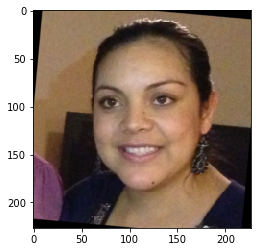

In [13]:
## FOR A PART OF THE DATA, IN CASE OF MEMORY ISSUE
print("len train_x dic : {} | len train_y dic : {}".format(len(train_x), len(train_y)))

number_of_sample = 200
def train_xy_lists(train_x, train_y):
    # Build the train_y and train_x lists from their corresponding dictionaries.
    train_x_list = []
    train_y_list = []
    
    # Before adding an image in the list, verify that it is in both train_x and train_y dictionaries
    # This to ensure that during the training process each image will have its correct label
    i=0
    for image_full_path in train_x:
        #print("I see the image full path JC ! : ", image)
        # Append the numerical image format using plt.imread(image_name_with_full_path) 
        if image_full_path in train_y and i<number_of_sample:
            #image = data.decode_jpeg(image_full_path)
            image = plt.imread(image_full_path)
            #image = np.newaxis(image)
            #image = data.distort_image(image, height, width)
            #image = data.distort_image(image, 224, 224)
            #train_x_list.append(plt.imread(image))
            train_x_list.append(image)
            train_y_list.append(train_y[image_full_path])
            i +=1
    #print("IN FUNCTION // train_x : {} | train_y y_label : {}".format(train_x_list[0], train_y_list[0]))
    # Then resize the square image to 227 x 227 pixels
    train_x_list = [imresize(img_i, (227, 227)) for img_i in train_x_list]

            
    return train_x_list, train_y_list




print("\n ************ train_xy_lists tests **************  \n")
train_x_list, train_y_list =  train_xy_lists(train_x, train_y)
print("len train_x list : {} | len train_y list : {}".format(len(train_x_list), len(train_y_list)))
i=0
for elt in train_x_list:
    if i<=0:
        print("train_x_list : {} | \ntrain_x_list Image : {} | \ntrain_y_list y_label : {}".format(train_x_list[i][1,:2], plt.imshow(train_x_list[i]), train_y_list[i]))
        print("train_x_list image Shape :", elt.shape)
        i +=1

print("\n *****************************************  \n\n\n")

<a name="Validation_xy_lists"></a>
### I.6.2- The Validation_x and Validation_y lists

In [ ]:
# 

<a name="Test_xy_lists"></a>
### I.6.3- The Test_x and Test_y lists


len test_x dic : 16153 | len test_y dic : 16153
!!! Don't forget to uncomment the full test dataset section, during the training process !!!.


 ************ train_xy_lists tests **************  

len test_x list : 200 | len test_y list : 200
test_X_list : [[0 0 0]
 [0 0 0]] ... | 
test_X_list Image : AxesImage(54,36;334.8x217.44) | 
test_Y_list y_label : [ 1.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
test_X_list image Shape : (227, 227, 3)

 *****************************************  





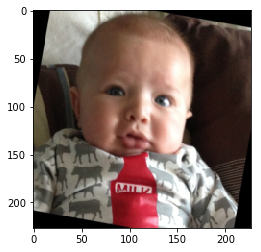

In [14]:
## THE REDUCED PART OF THE DATA IS TO USE IN CASE OF MEMORY ISSUE
print("len test_x dic : {} | len test_y dic : {}".format(len(test_x), len(test_y)))
print("!!! Don't forget to uncomment the full test dataset section, during the training process !!!.\n")

number_of_sample = 200
# Be aware that a sample of 200 images/16.000 is underfitted. It is just for test 
# or allowing the application running in case of memory issue.
def test_xy_lists(test_x, test_y):
    # Build the train_y and train_x lists from their corresponding dictionaries.
    test_x_list = []
    test_y_list = []
    
    # Before adding an image in the list, verify that it is in both train_x and train_y dictionaries
    # This to ensure that during the training process each image will have its correct label
    i=0
    for image_full_path in test_x:
        # Append the numerical image format using plt.imread(image_name_with_full_path) 
        if image_full_path in test_y and i<number_of_sample:
            image = plt.imread(image_full_path)
            test_x_list.append(image)
            test_y_list.append(test_y[image_full_path])
            i +=1
    
    # With the full images
    #for image_full_path in test_x:
    #    image = plt.imread(image_full_path)
    #    test_x_list.append(image)
    #    test_y_list.append(test_y[image_full_path])

    # Then resize the square image to 227 x 227 pixels
    test_x_list = [imresize(img_i, (227, 227)) for img_i in test_x_list]

            
    return test_x_list, test_y_list




print("\n ************ train_xy_lists tests **************  \n")
test_X_list, test_Y_list =  test_xy_lists(test_x, test_y)
print("len test_x list : {} | len test_y list : {}".format(len(test_X_list), len(test_Y_list)))
i=0
for elt in test_X_list:
    if i==1:
        print("test_X_list : {} ... | \ntest_X_list Image : {} | \ntest_Y_list y_label : {}".format(test_X_list[i][1,:2], plt.imshow(test_X_list[i]), test_Y_list[i]))
        print("test_X_list image Shape :", elt.shape)
        #print("test_X_list image type :", elt.type)
    i +=1

print("\n *****************************************  \n\n\n")

<a name="age_gender_prediction"></a>
# II- Age and Gender Prediction


In this part, we will pass the time training an artificial neural network model to learn how to predict age and gender of unseen images. For this purposes, we will use the **train_x_list** and **train_y_list** we previously built. 
The model will learn for each image in ***train_x_list*** its label (the corresponding one-hot label) in ***train_y_list***. And so, it will be able to predict the labels on unseen images. It will generate a one-hot label of 10 dimensions. So, according to the value we will know the age and gender of the image.

- This step will be useful for the mobile App. For each image the app should give its gender and age, and then propose the user to chose a class for aging process on the same image.

<font color='red'><br/>Note: <br/>Here, remember that a model which works well could need **several days on a modern GPU to be trained**.<br/>So **it could take a long time to train a good model, moreover on CPU systems.**<br/>Because of this, we will save the training model for futur use.</font>

<a name="ANN_Model"></a>
## II.1- Build the Artificial Neural Network (ANN) Model
<a name="ANN_Model_TFlearn"></a>
### II.1.1- With TFlearn

In [15]:
os.getcwd()
print("Current path: ", os.getcwd())

data_dir = '/notebooks/AgeGenderDeepLearning/Folds/train_val_txt_files_per_fold/test_fold_is_0/'
#data_dir = 'tensorflow-udacity\AgeGenderDeepLearning\Folds\train_val_txt_files_per_fold\test_fold_is_0'
#images, labels, _ = data.distorted_inputs(data_dir, batch_size=128, image_size=227, num_preprocess_threads=4)

Current path:  C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\tensorflow\tensorflow\examples\udacity


In [16]:

print("\n ************ START Build Artificial neural network Model **************  \n")
# Build neural network
#net = tflearn.input_data(shape=[None, 5])
# the image max shape is imsize = 600 ==> 600 * 600 = 360000
#net = tflearn.input_data(shape=[None, 51529])
net = tflearn.input_data(shape=[None, 227, 227, 3])

#net = tflearn.fully_connected(net, 32)
#net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 256)
net = tflearn.fully_connected(net, 256)
#net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.fully_connected(net, 10, activation='softmax')
net = tflearn.regression(net)

# Define model and setup tensorboard
model = tflearn.DNN(net, tensorboard_dir='tflearn_logs')
# Start training (apply gradient descent algorithm)
print("len train_x : {} | len train_y : {}".format(len(train_x_list), len(train_y_list)))
model.fit(train_x_list, train_y_list, n_epoch=10, batch_size=16, show_metric=True)
#model.fit(train_x_list, train_y_list, n_epoch=18, batch_size=16, show_metric=True)
#model.fit(images, labels, n_epoch=18, batch_size=16, show_metric=True)

print("\n ************ END Build Artificial neural network Model **************  \n")


Training Step: 129  | total loss: 34.96202 | time: 5.842s
| Adam | epoch: 010 | loss: 34.96202 - acc: 0.0000 -- iter: 192/200
Training Step: 130  | total loss: 34.63188 | time: 6.484s
| Adam | epoch: 010 | loss: 34.63188 - acc: 0.0000 -- iter: 200/200
--

 ************ END Build Artificial neural network Model **************  



<a name="ANN_Model_Tensorflow"></a>
### II.1.2- With Tensorflow

In [17]:
# As Tensorflow has now integrated TFlearn in his framework, we will implement the same model with the corresponding
# built-in function.


<a name="prediction_on_Model"></a>
## II.2- Predictions on the Model
<a name="prediction_on_dataset"></a>
### II.2.1- With images from the dataset

In [18]:
print("\n\n ************ START Model Prediction **************  \n")
images_to_plot = []
#print(test_X_list[1])
#image_to_predict = np.array(test_X_list[1]).astype(np.float32)
#print(image_to_predict)
print("==============> WITH THE test dataset")
image_to_predict = (test_X_list[0])[np.newaxis]
print("test dataset image shape : ", image_to_predict.shape)
print("Label Prediction on the test dataset image : ", model.predict(image_to_predict))
print("True Label Value : ", test_Y_list[0])
images_to_plot.append(test_X_list[0])
#plt.imshow(test_X_list[0])





# predict the one-hot label on unseen images
#print(model.predict([[0, 0, 0, 1, 1]]))




 ************ START Model Prediction **************  

==============> WITH THE test dataset
test dataset image shape :  (1, 227, 227, 3)
Label Prediction on the test dataset image :  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]
True Label Value :  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  1.]


<a name="prediction_on_otherFaces"></a>
### II.2.2- With other face images

In [20]:
print("\n==============> WITH my own image")
# Prediction with my own image

if int(PyVersion[0])==2:
    data_dir_jc_photo = '/notebooks/Kouassi-Jean-Claude-ID.png'
elif int(PyVersion[0])==3:
    data_dir_jc_photo = 'C:\\Users\\Jean-Claude KOUASSI\\tensorflow-udacity\\Kouassi-Jean-Claude-ID.png'
                
jc_image = plt.imread(data_dir_jc_photo)
jc_image = imresize(jc_image, (227, 227))
images_to_plot.append(jc_image)
#plt.imshow(jc_image)
jc_image = jc_image[np.newaxis]
print("jc_image shape : ", jc_image.shape)
print("Label Prediction with JC Photo: ", model.predict(image_to_predict))
print("True Label Value : [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]]")



==============> WITH my own image
jc_image shape :  (1, 227, 227, 4)
Label Prediction with JC Photo:  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]
True Label Value : [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]]


<a name="prediction_on_NonFaces"></a>
### II.2.3- With non-faces images


==============> WITH a non-face image
other_image shape :  (1, 227, 227, 3)
Label Prediction with another image:  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]
True Label Value : Here we have a picture of fishes

 ************ END Model Prediction **************  



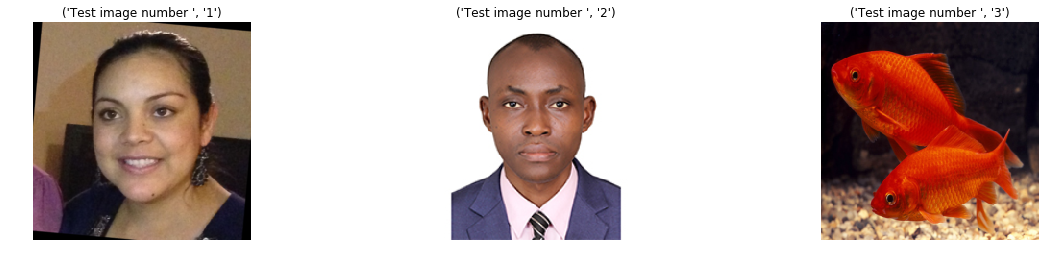

In [21]:
print("\n==============> WITH a non-face image")
# Prediction on unsuitable image (several faces, or animals)
if int(PyVersion[0])==2:
    data_dir_other = '/notebooks/Fish.JPEG'
elif int(PyVersion[0])==3:
    data_dir_other = 'C:\\Users\\Jean-Claude KOUASSI\\tensorflow-udacity\\Fish.JPEG'

other_image = plt.imread(data_dir_other)
other_image = imresize(other_image, (227, 227))
images_to_plot.append(other_image)

other_image = other_image[np.newaxis]
print("other_image shape : ", other_image.shape)
print("Label Prediction with another image: ", model.predict(image_to_predict))
print("True Label Value : Here we have a picture of fishes")



fig, axs = plt.subplots(1, len(images_to_plot), figsize=(20, 4))
for i, ax_i in enumerate(axs):
    NewTitle = "Test image number ", str(i+1)
    ax_i.imshow(images_to_plot[i])
    ax_i.set_title(NewTitle)
    ax_i.grid('off')
    ax_i.axis('off')
    
print("\n ************ END Model Prediction **************  \n")


EXECUTE THIS TO SAVE THE MODEL

In [22]:
### MODEL SAVING
model.save('model.tflearn')

INFO:tensorflow:C:\Users\Jean-Claude KOUASSI\tensorflow-udacity\tensorflow\tensorflow\examples\udacity\model.tflearn is not in all_model_checkpoint_paths. Manually adding it.


<a name="acgGAN_implementation"></a>
# III- The agcGAN implementation


<font color='red'>Note: <br/>Here, remember that the acGAN in the original paper took **about one day on a modern GPU to be trained**, for only 100 epochs and a dataset of about 30.000 face images.<br/>So **it could take a long time to train a model which works well, moreover on CPU systems.**<br/>For example, **on an Intel Core-i3-2350M CPU with 6 Go of RAM, it requires about 25 days to be trained.**<br/>Because of this, we will save the training model for futur use.</font>

### The agcGAN itself
Here, as explained in our github Readme, we will start with the standard conditional GAN (cGAN) provided by [Kristiadi Agustinus on the MNIST dataset](http://wiseodd.github.io/techblog/2016/12/24/conditional-gan-tensorflow/) to build the agcGAN.

In this implementation, the author uses the MNIST data which is already organized with its classes and functions. It is good for teachning things. So, the major modifications to meet the acgGAN will be:

- **The input shape.** Indeed, the MNIST images as the shape ***(1,28,28,1)*** because they are printed in black and white with only one channel. They input shape is ***(number_of_images, 784)***. For us, our images will be in RGB format with the shape ***(1, image_width, image_height, 3)***. 3 is the deph of the images (the number of channel) will allows us to print them in color. So our input shape will be **(number_of_images, image_width x image_heigh x image_deph)**. For a X_dim of 227 we will have the shape ***(number_of_images, 227 x 227 x 3)*** ==> **(None, 154587)**.
- **Update the weights and biases** according to the new shape of the input.
- **Write your own next_batch function** for the training process.
- **Adapt the plot function** to the desired task.
- Another specific point is to **define a function for aging**. Indeed, according to a input age ***y label***, this function should transform it to another ***y' label*** with the desired age to apply.

The data will be those we previously prepared (above).
    - train_x_list, 
    - train_y_list.
We will use the same method as in IcGAN, but this time applied to the age and gender conditions.

![alt tag](IcGAN.png)
   * ***Figure 1: The Inverted Conditional GAN process***

The IcGAN is trained in four steps.

    1. Train the generator.
    2. Create a dataset of generated images with the generator.
    3. Train the encoder Z to map an image x to a latent representation z with the dataset generated images.
    4. Train the encoder Y to map an image x to a conditional information vector y with the dataset of real images.


So as in the [acGAN Paper](http://arxiv.org/abs/1702.01983) which inspires us :

1- We will use the ***same design for the generator G and the discriminator D as in [[15]](https://arxiv.org/abs/1511.06434)***.

2- Following the IcGAN implementation, we will ***inject the conditional information at the input of G and at the first convolutional layer of D***. (Torch implementation code available at https://github.com/Guim3/IcGAN).

<a name="parameter_setting"></a>
## III.1- Parameters setting


In [ ]:
### The MNIST data images reshaping 
### They assume that shape[3] == 1  ||| In our case shape[3] == 3

#images = images.reshape(images.shape[0],
#                              images.shape[1] * images.shape[2])

In [23]:
## The images in our dataset need to be resized.

mb_size = 64
Z_dim = 100
Image_Depth = np.array(train_x_list).shape[3]
X_dim = np.array(train_x_list).shape[1]
y_dim = np.array(train_y_list).shape[1]
print("X_dim : {} | y_dim : {} | Image_Depth : {}".format(X_dim, y_dim, Image_Depth))
h_dim = 128


X_dim : 227 | y_dim : 10 | Image_Depth : 3


<a name="next_batch_function"></a>
## III.2- Next Batch function
The next batch method used here is inspired from the [Udacity Deep Learning](https://www.udacity.com/course/deep-learning--ud730) course, assignment 2 (2_fullyconnected).
You could also find other methods :
- On [KADENZE](https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info), session3.
- The [next_batch function](https://github.com/petewarden/tensorflow_makefile/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) of the MNIST Dataset.

In [26]:
# Test of the next_batch function
# Set successive values to the iteration (it) to see the results.
print("********** TEST OF THE NEXT_BATCH FUNCTION ***********\n")
print("Dataset lenght ", np.array(train_y_list).shape[0])
it = 1000000
print("Dataset shape ", np.array(train_y_list).shape)
print("Set the iteration Number to : ", it)

# THIS IS THE PROCESS TO GENERATE CORRECT VALUES OF OFFSET FOR LOOPING THROUGH THE DATA
#offset = (it * mb_size) % (np.array(train_y_list).shape[0] - mb_size)
offset = (it * mb_size) % (np.array(train_y_list).shape[0])

X_mb = np.array(train_x_list)[offset:(offset + mb_size), :]
y_mb = np.array(train_y_list)[offset:(offset + mb_size), :]
X_mbc = X_mb.copy()
X_mbc = np.reshape(X_mbc, (64,227*227*3))


print("\nCORRESPONDING VALUES ==================>")
print("OFFSET shape : {} |\nX_mb shape : {} |\ny_mb shape : {}".format(offset, X_mb.shape, y_mb.shape))
print("Sliced part : [{}:{}, :]".format(offset, (offset + mb_size)))
print("New X_mb Shape : ", X_mbc.shape)
print("\n********** END TEST OF THE NEXT_BATCH FUNCTION ***********\n")

********** TEST OF THE NEXT_BATCH FUNCTION ***********

Dataset lenght  200
Dataset shape  (200, 10)
Set the iteration Number to :  1000000

CORRESPONDING VALUES ==================>
OFFSET shape : 0 |
X_mb shape : (64, 227, 227, 3) |
y_mb shape : (64, 10)
Sliced part : [0:64, :]
New X_mb Shape :  (64, 154587)

********** END TEST OF THE NEXT_BATCH FUNCTION ***********



<a name="aging_label_function"></a>
## III.3- The aging label function

In [ ]:
# The function will transform a predicted label to another one with respect to the selected age.
# If we desire, we could keep the gender of the predicted label.
# See the Change Vector of Figure 1 for more details.


<a name="Generate_labels_cVAE"></a>
## III.4- Generate labels with an cVAE (as for the ANN Model)

In [ ]:
# As we did it for the ANN Model, we could also use a cVAE (Conditional Variational Auto-Encoder) to generate 
# (predict) the labels.
# We should compare the difference when we use cVAE or the ANN Model for label prediction.

#### With the ANN Model, we can load and call the model like below
model = DNN(net)
model.load('model.tflearn')
model.predict(image_to_predict)

#### With a cVAE Model (To be done)


<a name="agcGAN_Network"></a>
## III.5- The agcGAN Network
<a name="agcGAN_Network_implementation"></a>
### III.5.1- The agcGAN Network implementation
<font color='red'>Note: To run the ***agcGAN on the whole dataset***, don't forget to un/comment the required sections in ***I.6.1.*** and ***I.6.3***.</font>

In [27]:


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


""" Discriminator Net model """
# 227 * 227 = 51529 = X_dim * X_dim
# net = tflearn.input_data(shape=[None, 227, 227, 3])
X = tf.placeholder(tf.float32, shape=[None, X_dim * X_dim*Image_Depth])
X_2 = tf.placeholder(tf.float32, shape=[None, 227, 227, 3])
y = tf.placeholder(tf.float32, shape=[None, y_dim])
#y = tf.placeholder(tf.float32, shape=[y_dim])

D_W1 = tf.Variable(xavier_init([X_dim * X_dim*Image_Depth + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


def discriminator(x, y):
    inputs = tf.concat(axis=1, values=[x, y])
    print("inputs : ", inputs)
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


""" Generator Net model """
#Z = tf.placeholder(tf.float32, shape=[None, Z_dim*Z_dim])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

#G_W1 = tf.Variable(xavier_init([Z_dim*Z_dim + y_dim, h_dim]))
G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim * X_dim*Image_Depth]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim * X_dim*Image_Depth]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(z, y):
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        print("sample shape : ", sample.shape)
        #image Shape : (227, 227, 3)
        sample = np.reshape(sample, (X_dim, X_dim, Image_Depth))
        print("sample shape after reshape : ", sample.shape)
        
        plt.imshow(sample)

    return fig


G_sample = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Variable to save the agcGAN model
ckpt_name = "agcGAN.ckpt"
saver = tf.train.Saver()

# Load an existing checkpoint if it exists to continue training.
if os.path.exists(ckpt_name + '%' + '.index') or os.path.exists(ckpt_name+ '%s'):
#if tf.train.checkpoint_exists(ckpt_name):
    saver.restore(sess, ckpt_name)
    print("<=========================>")
    print("==> agcGAN model restored.")
    print("<=========================>")


if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

# For the training process we need to fix the desired output. 
# For example, no matter the input data, we could choose to generate it with the age class of
# [48, 53] (the 7th age class, i.e number 6 in one-hot label) and as a male (the 9th position, i.e number 8). 
for it in range(1000000):
    if it % 10 == 0:
        n_sample = 16

        #Z_sample = sample_Z(n_sample, Z_dim*Z_dim)
        Z_sample = sample_Z(n_sample, Z_dim)
        y_sample = np.zeros(shape=[n_sample, y_dim]) # Our y'
        
        #############################################
        # Here we will use the aging label function applied to the predicted label
        # And then set the gender label with
        # For the age which will be used for the aging process, we will fix it with respect to the
        # user selection
        y_sample[:, 6] = 1
        y_sample[:, 8] = 1
        
        # Generated samples
        samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
        print("samples elements shape : {} ".format(samples[0].shape))
        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        
        
    #############################################
    # THE NEXT BATCH FUNCTION
    offset = (it * mb_size) % (np.array(train_y_list).shape[0])
    X_mb = np.array(train_x_list)[offset:(offset + mb_size), :]
    y_mb = np.array(train_y_list)[offset:(offset + mb_size), :]
    print("X_mb shape : {} | X_mb size : {} | y_mb shape : {}".format(X_mb.shape, X_mb.size, y_mb.shape))
    
    # Reshape it to map the content to the rest of the process
    X_mb = np.reshape(X_mb, (X_mb.shape[0], X_dim*X_dim*Image_Depth))
    print("X_mb new shape2 : {} | y_mb shape : {}".format(X_mb.shape, y_mb.shape))
    
    #### BELOW, in comment, test of train.batch and train.shuffle_batch functions of tensorflow
    #### Still some errors (TO BE DONE)
    """
    images = []
    for image in train_x_list:
        image = np.reshape(image, (1, X_dim*X_dim*Image_Depth))
        images.append(image)
        
    #labels = np.array(train_y_list)
    
    X_mb, y_mb = tf.train.shuffle_batch(
          [images, train_y_list],
          batch_size=64,
          num_threads=1,
          capacity=50000,
          min_after_dequeue=12)
    print("X_mb shape : {} | X_mb type : {} | y_mb shape : {}".format(X_mb.shape, X_mb.type, y_mb.shape))
    
    # With Train Batch
    X_mb, y_mb = tf.train.batch(
          [images, train_y_list],
          batch_size=64,
          num_threads=1,
          capacity=200)
    print("X_mb shape : {} | X_mb type : {} | y_mb shape : {}".format(X_mb.shape, X_mb.shape, y_mb.shape))
    """

    #Z_sample = sample_Z(mb_size, Z_dim)
    # This ensures that if the rest of the data is less than the batch size because of the slice operation
    # and number of available data, it will use the rest of data instead of the predefined number.
    # For example for data_size=200 and batch_size=64, at the 4th tour, the rest will be 200 - 64*3 = 8.
    Z_sample = sample_Z(X_mb.shape[0], Z_dim)
    print("\n\nZ_sample shape : {} | y_mb shape : {}".format(Z_sample.shape, y_mb.shape))
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

    if it % 10 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        
        
        #############################################
        # SAVE THE MODEL
        save_path = saver.save(sess, "./" + ckpt_name,
                               global_step=it,
                               write_meta_graph=False)
        print("Model saved in file: %s" % save_path)
print()

inputs :  Tensor("concat_1:0", shape=(?, 154597), dtype=float32)
inputs :  Tensor("concat_2:0", shape=(?, 154597), dtype=float32)
samples elements shape : (154587,) 
sample shape :  (154587,)
sample shape after reshape :  (227, 227, 3)
sample shape :  (154587,)
sample shape after reshape :  (227, 227, 3)
sample shape :  (154587,)
sample shape after reshape :  (227, 227, 3)
sample shape :  (154587,)
sample shape after reshape :  (227, 227, 3)
sample shape :  (154587,)
sample shape after reshape :  (227, 227, 3)
sample shape :  (154587,)
sample shape after reshape :  (227, 227, 3)
sample shape :  (154587,)
sample shape after reshape :  (227, 227, 3)
sample shape :  (154587,)
sample shape after reshape :  (227, 227, 3)
sample shape :  (154587,)
sample shape after reshape :  (227, 227, 3)
sample shape :  (154587,)
sample shape after reshape :  (227, 227, 3)
sample shape :  (154587,)
sample shape after reshape :  (227, 227, 3)
sample shape :  (154587,)
sample shape after reshape :  (227, 22

UnknownError: Failed to WriteFile: ./agcGAN.ckpt-40.data-00000-of-00001.tempstate10602711131841258842 : Espace insuffisant sur le disque.
; Unknown error
	 [[Node: save_4/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_BOOL, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_4/Const_0, save_4/SaveV2/tensor_names, save_4/SaveV2/shape_and_slices, Accuracy/Mean/moving_avg, Adam/beta1_power, Adam/beta2_power, Crossentropy/Mean/moving_avg, FullyConnected/W, FullyConnected/W/Adam, FullyConnected/W/Adam_1, FullyConnected/b, FullyConnected/b/Adam, FullyConnected/b/Adam_1, FullyConnected_1/W, FullyConnected_1/W/Adam, FullyConnected_1/W/Adam_1, FullyConnected_1/b, FullyConnected_1/b/Adam, FullyConnected_1/b/Adam_1, FullyConnected_2/W, FullyConnected_2/W/Adam, FullyConnected_2/W/Adam_1, FullyConnected_2/b, FullyConnected_2/b/Adam, FullyConnected_2/b/Adam_1, Global_Step, Training_step, Variable, Variable/Adam, Variable/Adam_1, Variable_1, Variable_1/Adam, Variable_1/Adam_1, Variable_2, Variable_2/Adam, Variable_2/Adam_1, Variable_3, Variable_3/Adam, Variable_3/Adam_1, Variable_4, Variable_4/Adam, Variable_4/Adam_1, Variable_5, Variable_5/Adam, Variable_5/Adam_1, Variable_6, Variable_6/Adam, Variable_6/Adam_1, Variable_7, Variable_7/Adam, Variable_7/Adam_1, beta1_power, beta1_power_1, beta2_power, beta2_power_1, is_training, val_acc, val_loss)]]

Caused by op 'save_4/SaveV2', defined at:
  File "C:\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-8520d47605b3>", line 102, in <module>
    saver = tf.train.Saver()
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1051, in __init__
    self.build()
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1081, in build
    restore_sequentially=self._restore_sequentially)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 673, in build
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 271, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 214, in save_op
    tensors)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 779, in save_v2
    tensors=tensors, name=name)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

UnknownError (see above for traceback): Failed to WriteFile: ./agcGAN.ckpt-40.data-00000-of-00001.tempstate10602711131841258842 : Espace insuffisant sur le disque.
; Unknown error
	 [[Node: save_4/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_BOOL, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_4/Const_0, save_4/SaveV2/tensor_names, save_4/SaveV2/shape_and_slices, Accuracy/Mean/moving_avg, Adam/beta1_power, Adam/beta2_power, Crossentropy/Mean/moving_avg, FullyConnected/W, FullyConnected/W/Adam, FullyConnected/W/Adam_1, FullyConnected/b, FullyConnected/b/Adam, FullyConnected/b/Adam_1, FullyConnected_1/W, FullyConnected_1/W/Adam, FullyConnected_1/W/Adam_1, FullyConnected_1/b, FullyConnected_1/b/Adam, FullyConnected_1/b/Adam_1, FullyConnected_2/W, FullyConnected_2/W/Adam, FullyConnected_2/W/Adam_1, FullyConnected_2/b, FullyConnected_2/b/Adam, FullyConnected_2/b/Adam_1, Global_Step, Training_step, Variable, Variable/Adam, Variable/Adam_1, Variable_1, Variable_1/Adam, Variable_1/Adam_1, Variable_2, Variable_2/Adam, Variable_2/Adam_1, Variable_3, Variable_3/Adam, Variable_3/Adam_1, Variable_4, Variable_4/Adam, Variable_4/Adam_1, Variable_5, Variable_5/Adam, Variable_5/Adam_1, Variable_6, Variable_6/Adam, Variable_6/Adam_1, Variable_7, Variable_7/Adam, Variable_7/Adam_1, beta1_power, beta1_power_1, beta2_power, beta2_power_1, is_training, val_acc, val_loss)]]


<a name="agcGAN_Network_Evaluation"></a>
### III.5.2- The agcGAN Network Evaluationn

In [ ]:
#Evaluation
#y_ = tf.placeholder("float", [None,10])
#y = tf.nn.softmax(tf.matmul(x,W) + b)
#correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))   # y=Y_pred  and y_=TrueY
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
#print sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

#logits = tf.matmul(outputs_flat, W) + b
#probs = tf.nn.softmax(logits)
#Y_pred = tf.argmax(probs, 1)

#D_logit = tf.matmul(D_h1, D_W2) + D_b2
#D_prob = tf.nn.sigmoid(D_logit)
correct_prediction = tf.equal(tf.argmax(D_prob,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

test_X_list = np.array(test_X_list)
test_X_list = np.reshape(test_X_list, (64,227*227*3))
test_Y_list = np.array(test_Y_list)
print sess.run(accuracy, feed_dict={X: test_X_list, y: test_Y_list})


<a name="acgGAN_Video"></a>
# IV- Video implementation of the acgGAN


Several possibilities :
- Using the [MoviePy](http://zulko.github.io/moviepy/index.html) Python module for video editing. It works on Windows, Mac, and Linux, with Python 2 or Python 3.
- [Python Live Video Streaming Example](http://www.chioka.in/python-live-video-streaming-example/)
- Using [scikit-video](https://github.com/aizvorski/scikit-video), a Video processing algorithms, including I/O, quality metrics, temporal filtering, motion/object detection, motion estimation...
- Using the [Continuous online video classification with TensorFlow](https://medium.com/@harvitronix/continuous-online-video-classification-with-tensorflow-inception-and-a-raspberry-pi-785c8b1e13e1) post on medium. The [Part2](https://medium.com/@harvitronix/continuous-video-classification-with-tensorflow-inception-and-recurrent-nets-250ba9ff6b85) includes examples on how to reuse TFLearn saved models.
- Applying the acgGAN function to **openCV** functions as in the [Udacity-Self-Driving-Car-Preview](https://github.com/Kjeanclaude/Udacity-SDC-Preview); look at the video part.


<a name="acgGAN_Mobile_App"></a>
# V- Deployment of the acgGAN on a Mobile App


There is not enough documentation for this task as I explained in the introduction. 
But we could find for Tensorflow some recents posts it is worth to try (all posted in March 2017). **Other methods are welcome, mostly universal methods (crossplatform supporting several Deep Learning frameworks).**

- [Deploying a TensorFlow model to Android](https://chatbotslife.com/deploying-a-tensorflow-model-to-android-69d04d1b0cba)
- [Creating Custom Model For Android Using TensorFlow](https://blog.mindorks.com/creating-custom-model-for-android-using-tensorflow-3f963d270bfb)

Below the intending functionalities of the App:
- Select a picture
- The App give the gender and age of the picture ("It seems that we have a 30 years old Woman in this picture")
- The App propose the user to choose the aging class {and even a gender, if he wishes}("Please, select your desired parameters for the process")
- The App computes and generates a picture according the user selection using the agcGAN implementation ("XXXX [name], this is how you should be according to your selection.")

We will try to increase the quality of images as we can (It is the challenge the original paper tried to overcome).
We should try to provide result closer to below (even if we could not have the same accuracy because of amount of data and class of ages available with platform such as Microsoft, Facebook, etc.).
- For the age and gender prediction on unseen images : https://how-old.net/ (Microsoft). It is very accurate.
- For the aging process : https://www.faceapp.io/. Below an example of aging generated with faceapp.
![alt tag](agingFaceApp.png)


<a name="conclusion"></a>
# CONCLUSION

We are thankful to Professor Jeremy and Rachel to have allowed us to participate to this awesome program of the [FAST AI courses, Part2](http://www.fast.ai/) as ***International Fellows***. Indeed, we have learned a lot of things and specificly the ***techniques on how to replicate, customize or reuse research papers, for practical projects implementation***. Thanks for all your advices.

We also thank the authors of the research paper which inspired our work, [Face Aging With Conditional Generative Adversarial Networks](http://arxiv.org/abs/1702.01983). Of course we could not have access to their private dataset, but we have been able to overpass the problem, implement our version of agcGAN and bring our contribution on the subject.

This work could be used as a tutorial for anyone interesting in this field.
* The main contribution had been:
- Provide tools to train the dataset either on GAN or other Artificial Neural Network
- Provide more categories of age (8 instead of 6), considering the provided dataset
- possibility to generate labels from an AE or another desired ANN and compare the difference.
- Turning the implementation in video and mobile application 
- Relate the performance values (to be done .......)

On the other hand to extend contribution on the field : 
- it would be worth to apply the same technic on other types of GAN, as it is a recent field always in exploration, ***mainly the Wasserstein GAN*** which produces accurate results.
- propose an universal and easy method for deployment of notebook implementations on a Mobile App

<font color='red'><br/>So, we are pleased to share this work with you. As it is said that there is no perfect human work, we are open to comment or suggestion. <br/>Any positive or negative feedback are welcome.<br/>Thank you !. <br/>==> <a href="https://github.com/Kjeanclaude">K. Jean-Claude</a><br/>==> <a href="https://github.com/shgidi">Gidi Shperber</a></font>